## Introdução

O presente projeto tem como objetivo realizar uma análise preditiva e exploratória sobre o comportamento de vendas em uma rede de supermercados, utilizando o dataset “Supermarket Sales”, disponível publicamente no Kaggle
.

O conjunto de dados contém registros de transações realizadas em três filiais de uma rede de supermercados localizadas em Yangon, Mandalay e Naypyitaw (Myanmar), ao longo de um período de três meses (janeiro a março de 2019). Cada transação inclui informações detalhadas sobre o tipo de cliente, gênero, categoria de produto, quantidade comprada, preço unitário, forma de pagamento, impostos, margem bruta e avaliação do cliente.

A partir desses dados, o projeto busca entender os padrões de consumo dos clientes e identificar fatores que influenciam as vendas e a satisfação. Além disso, será desenvolvido um modelo preditivo capaz de estimar o valor total da compra (ou a margem bruta) com base em características observadas na transação, auxiliando na tomada de decisão estratégica do negócio.

In [ ]:
pip install -r requirements.txt --qq

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   -- ------------------------------------- 4.5/72.0 MB 33.9 MB/s eta 0:00:02
   ------- -------------------------------- 13.4/72.0 MB 35.8 MB/s eta 0:00:02
   ----------- ---------------------------- 21.2/72.0 MB 35.7 MB/s eta 0:00:02
   ---------------- ----------------------- 29.9/72.0 MB 36.9 MB/s eta 0:00:02
   --------------------- ------------------ 39.3/72.0 MB 38.1 MB/s eta 0:00:01
   -------------------------- ------------- 48.0/72.0 MB 38.9 MB/s eta 0:00:01
   ------------------------------- -------- 56.4/72.0 MB 39.3 MB/s eta 0:00:01
   ----------------------------------- ---- 64.2/72.0 MB 39.0 MB/s eta 0:00:01
   ---------------------------------------  71.8/72.0 MB 39.7 MB/s eta 0:00:01
   ---------------------------------------  71.8/72.0 MB 39.7 MB/s eta 0:00:01
   ---------------------------------------- 72.0/72.0 MB 34.5 MB/s  0:00:02
Note: you may need to restart the kernel to use updated packages.


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Importação de Bibliotecas e Configurações Iniciais

In [2]:
# Bibliotecas essenciais
import numpy as np
import pandas as pd
import os

In [3]:
# Bibliotecas de visualização
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [4]:
# Bibliotecas de Machine Learning e Métricas
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, LassoCV

# Carregando e vialisando o DF

In [ ]:
# Carregamento dos dados
df = pd.read_csv('data\SuperMarket Analysis.csv' )


print("Shape do dataset:", df.shape)
print("\nInformações iniciais do dataset:")
df.info()

Shape do dataset: (1000, 17)

Informações iniciais do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Sales                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs            

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Ramos\AppData\Local\Temp\ipykernel_9456\3300759764.py:2: SyntaxWarning: invalid escape sequence '\D'
  df = pd.read_csv('D:\Documentos\VsCode\projetos_git\supermarket sales\data\SuperMarket Analysis.csv' )


### Análise Exploratória de Dados (EDA) e Limpeza

In [6]:
# Verificação de valores nulos e estatísticas
print("\nVerificação de valores nulos:")
print(df.isnull().sum())

print("\nEstatísticas descritivas:")
print(df.describe(include='all'))


Verificação de valores nulos:
Invoice ID                 0
Branch                     0
City                       0
Customer type              0
Gender                     0
Product line               0
Unit price                 0
Quantity                   0
Tax 5%                     0
Sales                      0
Date                       0
Time                       0
Payment                    0
cogs                       0
gross margin percentage    0
gross income               0
Rating                     0
dtype: int64

Estatísticas descritivas:
         Invoice ID Branch    City Customer type  Gender         Product line  \
count          1000   1000    1000          1000    1000                 1000   
unique         1000      3       3             2       2                    6   
top     750-67-8428   Alex  Yangon        Member  Female  Fashion accessories   
freq              1    340     340           565     571                  178   
mean            NaN    NaN     

### Identificação de Colunas Inúteis/Constantes

Comentário da Melhoria: A coluna gross margin percentage é uma constante em todo o dataset (4.76...) e não pode ser usada como feature preditiva.

In [7]:
# Identificação de colunas com valor único (constantes)
const_cols = [col for col in df.columns if df[col].nunique() <= 1]
print(f"\nColunas constantes a serem removidas: {const_cols}")

# Adiciona colunas que não serão usadas na modelagem
cols_to_drop = const_cols + ['Invoice ID'] 

df = df.drop(columns=cols_to_drop, axis=1)
print(f"\nColunas após remoção de constantes e ID: {df.columns.tolist()}")


Colunas constantes a serem removidas: ['gross margin percentage']

Colunas após remoção de constantes e ID: ['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Unit price', 'Quantity', 'Tax 5%', 'Sales', 'Date', 'Time', 'Payment', 'cogs', 'gross income', 'Rating']


### Feature Engineering (Engenharia de Características)

In [8]:
# Conversão para datetime
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'])

# Extração de Features Temporais
df['Year'] = df['Date'].dt.year
df['MonthName'] = df['Date'].dt.strftime('%B')
df['DayName'] = df['Date'].dt.strftime('%A')
df['Hour'] = df['Time'].dt.hour
df['TimeOfDay'] = pd.cut(df['Hour'], 
                         bins=[0, 12, 17, 21, 24], 
                         labels=['Morning', 'Afternoon', 'Evening', 'Night'], 
                         right=False)

# Remoção das colunas originais de data e hora
df = df.drop(columns=['Date', 'Time'])

C:\Users\Ramos\AppData\Local\Temp\ipykernel_9456\3436956220.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


In [9]:
df.columns

Index(['Branch', 'City', 'Customer type', 'Gender', 'Product line',
       'Unit price', 'Quantity', 'Tax 5%', 'Sales', 'Payment', 'cogs',
       'gross income', 'Rating', 'Year', 'MonthName', 'DayName', 'Hour',
       'TimeOfDay'],
      dtype='object')

### Análise Visual (EDA Aprofundada)

Visualizações para entender como as variáveis categóricas se relacionam com o alvo (Sales).

<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:27: SyntaxWarning: invalid escape sequence '\D'
<>:36: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:27: SyntaxWarning: invalid escape sequence '\D'
<>:36: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Ramos\AppData\Local\Temp\ipykernel_9456\826498689.py:8: SyntaxWarning: invalid escape sequence '\D'
  plt.savefig("D:\Documentos\VsCode\projetos_git\supermarket sales\outputs\Distribuição da Receita.png")
C:\Users\Ramos\AppData\Local\Temp\ipykernel_9456\826498689.py:18: SyntaxWarning: invalid escape sequence '\D'
  plt.savefig("D:\Documentos\VsCode\projetos_git\supermarket sales\outputs\Sales por Linha de Produto.png")
C:\Users\Ramos\AppData\Local\Temp\ipykernel_9456\826498689.py:27: SyntaxWarning: invalid escape sequence '\D'
  plt.savefig("D:\Documentos\VsCode\projetos_git\sup

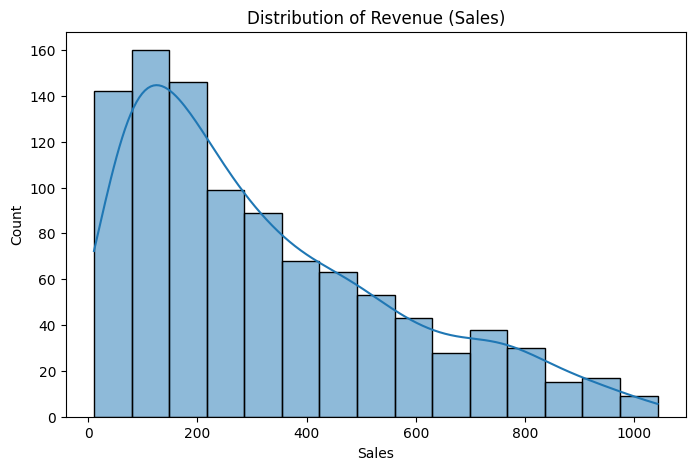

<Figure size 640x480 with 0 Axes>

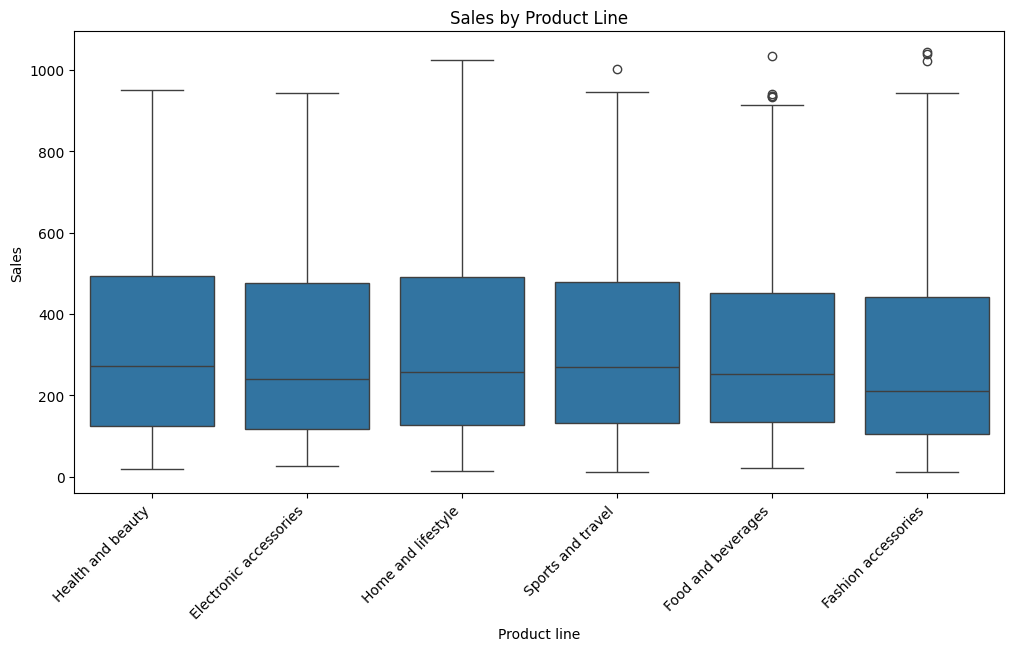

<Figure size 640x480 with 0 Axes>

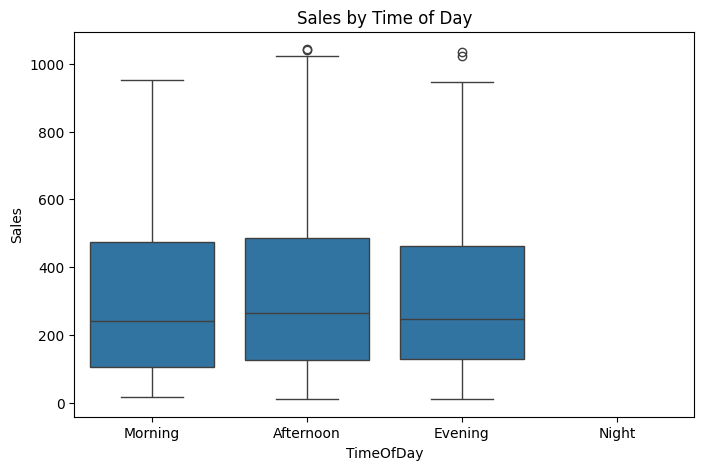

<Figure size 640x480 with 0 Axes>

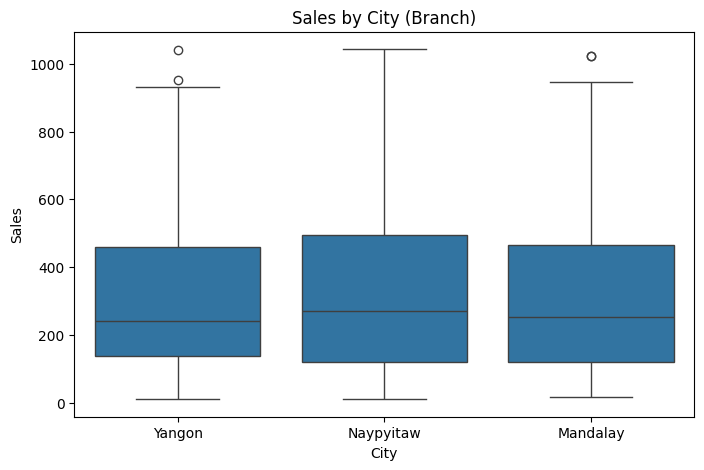

<Figure size 640x480 with 0 Axes>

In [ ]:
# Distribution of the target variable
plt.figure(figsize=(8, 5))
sns.histplot(df['Sales'], kde=True)
plt.title('Distribution of Revenue (Sales)')
plt.show()

# Save graph
plt.savefig("outputs\Distribuição da Receita.png")

# Relationship between product line and price (Sales)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Product line', y='Sales', data=df)
plt.title('Sales by Product Line')
plt.xticks(rotation=45, ha='right')
plt.show()

# Save graph
plt.savefig("outputs\Sales por Linha de Produto.png")

# Relationship between time of day and price (Sales)
plt.figure(figsize=(8, 5))
sns.boxplot(x='TimeOfDay', y='Sales', data=df, order=['Morning', 'Afternoon', 'Evening', 'Night'])
plt.title('Sales by Time of Day')
plt.show()

# Save graph
plt.savefig("outputs\Sales por Período do Dia.png")

# Relationship between city and price (Sales)
plt.figure(figsize=(8, 5))
sns.boxplot(x='City', y='Sales', data=df)
plt.title('Sales by City (Branch)')
plt.show()

# Save graph
plt.savefig("outputs\Sales por Cidade (Filial).png")

### Pré-processamento Final e Divisão dos Dados

Codificação One-Hot para variáveis categóricas e divisão em conjuntos de treino e teste.

In [11]:
df.columns

Index(['Branch', 'City', 'Customer type', 'Gender', 'Product line',
       'Unit price', 'Quantity', 'Tax 5%', 'Sales', 'Payment', 'cogs',
       'gross income', 'Rating', 'Year', 'MonthName', 'DayName', 'Hour',
       'TimeOfDay'],
      dtype='object')

In [12]:
df = df.drop(columns=['Branch'])


df.head(5)

,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Payment,cogs,gross income,Rating,Year,MonthName,DayName,Hour,TimeOfDay
0,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,Ewallet,522.83,26.1415,9.1,2019,January,Saturday,13,Afternoon
1,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,Cash,76.40,3.8200,9.6,2019,March,Friday,10,Morning
2,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.2155,340.5255,Credit card,324.31,16.2155,7.4,2019,March,Sunday,13,Afternoon
3,Yangon,Member,Female,Health and beauty,58.22,8,23.2880,489.0480,Ewallet,465.76,23.2880,8.4,2019,January,Sunday,20,Evening
4,Yangon,Member,Female,Sports and travel,86.31,7,30.2085,634.3785,Ewallet,604.17,30.2085,5.3,2019,February,Friday,10,Morning


In [13]:
# One-Hot Encoding
df = pd.get_dummies(df, drop_first=True)



<>:28: SyntaxWarning: invalid escape sequence '\D'
<>:28: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Ramos\AppData\Local\Temp\ipykernel_9456\622215957.py:28: SyntaxWarning: invalid escape sequence '\D'
  plt.savefig("D:\Documentos\VsCode\projetos_git\supermarket sales\outputs\Top 20 Correlations with the Target Variable (Sales) After One-Hot Encoding.png")
C:\Users\Ramos\AppData\Local\Temp\ipykernel_9456\622215957.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_corr.values, y=top_20_corr.index, palette=colors)


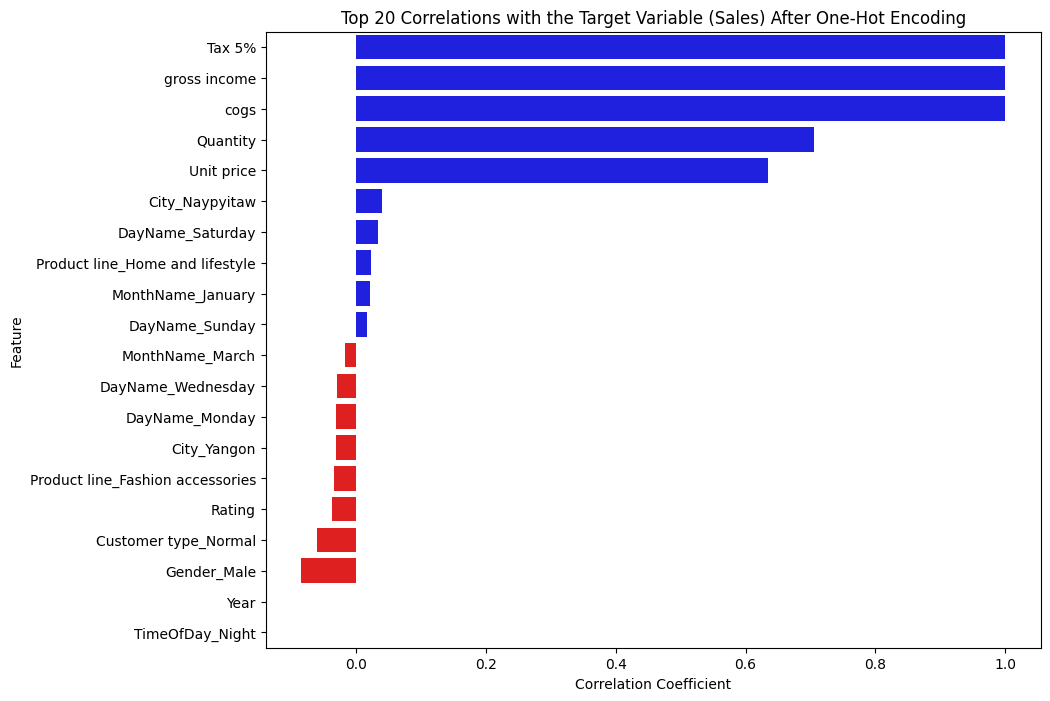

<Figure size 640x480 with 0 Axes>

In [ ]:
# Assuming 'df' is your DataFrame after pd.get_dummies()

# 1. Calculate the correlation of all columns with 'Sales'
correlation_with_target = df.corr()['Sales'].sort_values(ascending=False)

# 2. Remove the correlation of 'Sales' with itself
correlation_with_target = correlation_with_target.drop('Sales')

# 3. Visualize the TOP 20 Features (the most correlated, positively and negatively)
# We combine the 10 most positive and the 10 most negative (ignoring Sales itself)
top_positive = correlation_with_target.head(10)
top_negative = correlation_with_target.tail(10)

# Combine and sort for plotting
top_20_corr = pd.concat([top_positive, top_negative]).sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
# We use the color of the coefficient (positive or negative)
colors = ['red' if c < 0 else 'blue' for c in top_20_corr.values]
sns.barplot(x=top_20_corr.values, y=top_20_corr.index, palette=colors)
plt.title('Top 20 Correlations with the Target Variable (Sales) After One-Hot Encoding')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.show()

# Save plot
plt.savefig("outputs\Top 20 Correlations with the Target Variable (Sales) After One-Hot Encoding.png")

In [15]:
df.columns

Index(['Unit price', 'Quantity', 'Tax 5%', 'Sales', 'cogs', 'gross income',
       'Rating', 'Year', 'Hour', 'City_Naypyitaw', 'City_Yangon',
       'Customer type_Normal', 'Gender_Male',
       'Product line_Fashion accessories', 'Product line_Food and beverages',
       'Product line_Health and beauty', 'Product line_Home and lifestyle',
       'Product line_Sports and travel', 'Payment_Credit card',
       'Payment_Ewallet', 'MonthName_January', 'MonthName_March',
       'DayName_Monday', 'DayName_Saturday', 'DayName_Sunday',
       'DayName_Thursday', 'DayName_Tuesday', 'DayName_Wednesday',
       'TimeOfDay_Afternoon', 'TimeOfDay_Evening', 'TimeOfDay_Night'],
      dtype='object')

In [16]:
df = df.drop(columns=['Unit price', 'Quantity', 'Tax 5%','cogs', 'gross income'])

In [17]:

# Definição de X (features) e y (target)
X = df.drop('Sales', axis=1)
y = df['Sales']

In [18]:
# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

### Modelagem Preditiva com Otimização (XGBoost)

Aplicação de RandomizedSearchCV para encontrar a melhor combinação de hiperparâmetros para o XGBRegressor, garantindo um modelo mais robusto.

In [19]:
# Definição do modelo
xgb_model = XGBRegressor(random_state=42)

# Grid de parâmetros para otimização (apenas alguns exemplos)
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

# Inicialização do Randomized Search
# n_iter=20 significa que 20 combinações aleatórias serão testadas
random_search = RandomizedSearchCV(estimator=xgb_model, 
                                   param_distributions=param_dist, 
                                   n_iter=20, 
                                   scoring='neg_mean_squared_error', 
                                   cv=3, 
                                   verbose=1, 
                                   random_state=42, 
                                   n_jobs=-1)

# Treinamento do modelo otimizado
print("\nIniciando Randomized Search para otimização de hiperparâmetros...")
random_search.fit(X_train, y_train)

# Melhor modelo
best_xgb = random_search.best_estimator_

print("\nMelhores Hiperparâmetros encontrados:")
print(random_search.best_params_)


Iniciando Randomized Search para otimização de hiperparâmetros...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Melhores Hiperparâmetros encontrados:
{'subsample': 0.9, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.9}


###  Avaliação e Interpretação do Modelo

In [20]:
# Predição com o melhor modelo
y_pred = best_xgb.predict(X_test)

# Cálculo das métricas
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(" Avaliação do Melhor Modelo XGBoost (Após Tuning) \n")
print(f"MSE: {mse:.2f}")
print(f"R: {r2:.4f}")
print(f"MAE: {mae:.2f}")

# Observação: Espera-se que o R² seja significativamente menor que 0.90, mas isso 
# reflete a complexidade real da previsão, sem a ajuda de features vazadas.

 Avaliação do Melhor Modelo XGBoost (Após Tuning) 

MSE: 65623.00
R: -0.0087
MAE: 210.82


In [21]:
model = LassoCV()
# Treinando o modelo

model.fit(X_train, y_train)


y_pred = model.predict(X_test)


MSE_LassoCV = mean_squared_error(y_test, y_pred)

print(f'MSE: {MSE_LassoCV}')

R2_LassoCV = r2_score(y_test, y_pred)
print(f'R²: {R2_LassoCV:.4f}')


MAE_LassoCV = mean_absolute_error(y_test, y_pred)
print(f'MAE: {MAE_LassoCV}')

MSE: 65406.2414260815
R²: -0.0053
MAE: 209.771352


In [22]:
model = LinearRegression()
# Treinando o modelo

model.fit(X_train, y_train)


y_pred = model.predict(X_test)


MSE_LinearRegression = mean_squared_error(y_test, y_pred)

print(f'MSE: {MSE_LinearRegression}')

R2_LinearRegression = r2_score(y_test, y_pred)
print(f'R²: {R2_LinearRegression:.4f}')


MAE_LinearRegression = mean_absolute_error(y_test, y_pred)
print(f'MAE: {MAE_LinearRegression}')

MSE: 68049.2807611281
R²: -0.0460
MAE: 214.8769976191942


### Interpretação das Features (Permutation Importance)

Plotagem mais clara dos resultados de permutation importance.


<>:24: SyntaxWarning: invalid escape sequence '\D'
<>:24: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Ramos\AppData\Local\Temp\ipykernel_9456\3881838044.py:24: SyntaxWarning: invalid escape sequence '\D'
  plt.savefig(f"D:\Documentos\VsCode\projetos_git\supermarket sales\outputs\Permutation Importance - Top {top_features} Features.png")


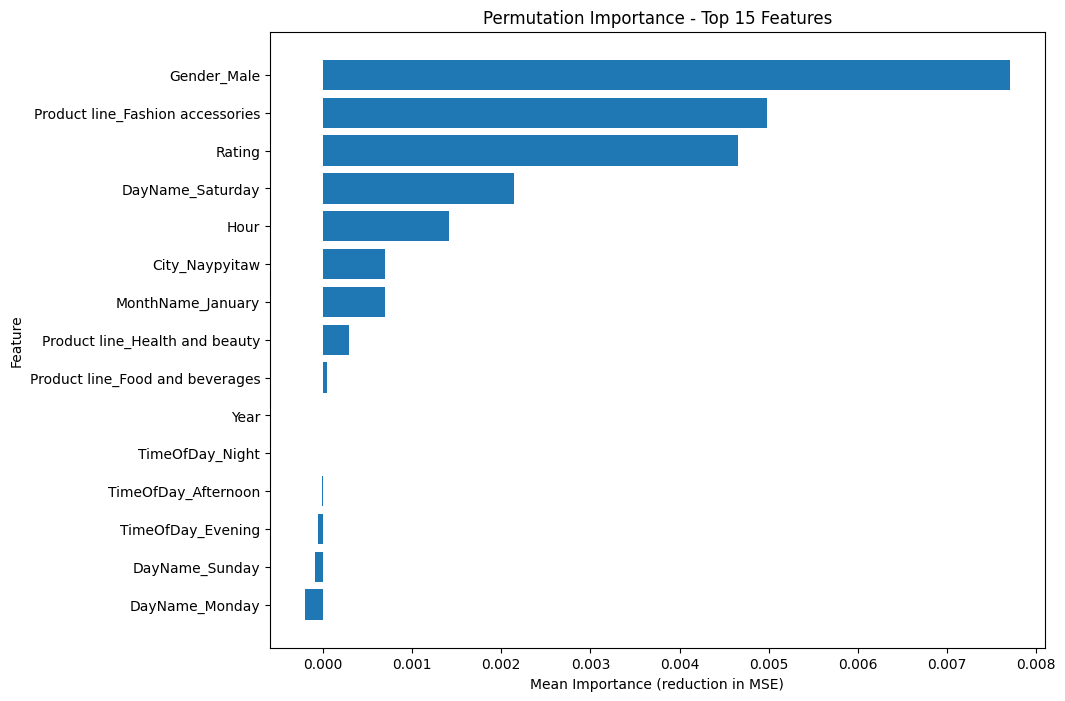

<Figure size 640x480 with 0 Axes>

In [ ]:
# Calculation of Permutation Importance
# Uses the test set (X_test) for a more accurate evaluation
results = permutation_importance(best_xgb, X_test, y_test,
n_repeats=10,
random_state=42,
n_jobs=-1)

# Organization and Plotting
feature_names = X_test.columns
sorted_idx = results.importances_mean.argsort()[::-1]

# Top 15 Features
top_features = 15
plt.figure(figsize=(10, 8))
plt.barh(feature_names[sorted_idx][:top_features],
results.importances_mean[sorted_idx][:top_features])
plt.xlabel("Mean Importance (reduction in MSE)")
plt.ylabel("Feature")
plt.title(f"Permutation Importance - Top {top_features} Features")
plt.gca().invert_yaxis()
plt.show()

# Save plot
plt.savefig(f"outputs\Permutation Importance - Top {top_features} Features.png")